#Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import xgboost as xgb
from collections import Counter
import numpy as np
import itertools
from pathlib import Path
import pandas as pd
from collections import Counter
from itertools import product
import numpy as np, pandas as pd, re
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

2025-09-18 16:27:55.926091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758212875.948341    1875 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758212875.955411    1875 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Data-Sets

In [ ]:
def load_fasta_file(path: Path):
    seqs, labs = [], []
    lines = path.read_text().splitlines()
    for i in range(0, len(lines), 2):
        header = lines[i].strip()
        if not header:
            continue
        seq  = lines[i+1].strip() if i+1 < len(lines) else ""
        labs.append(1 if "Positive" in header or ">1" in header or "positive" in header or "POSITIVE" in header else 0)
        seqs.append(seq.upper())
    return seqs, labs

def load_fasta_data(data_dir, files):
    seqs, labs, per_file_counts = [], [], {}
    for fname in files:
        seq, lab = load_fasta_file(Path(data_dir) / fname)
        seqs.extend(seq)
        labs.extend(lab)
        per_file_counts[fname] = Counter(lab)

    lengths = [len(s) for s in seqs]
    min_len = min(lengths)
    max_len = max(lengths)

    df = pd.DataFrame({"seq": seqs, "label": labs})

    print(f"Shortest sequence  {min_len}")
    print(f"Longest  sequence  {max_len}")

    print(f"\nTotal sequences : {len(df):,}")
    print(f"Class balance   : {Counter(df.label)}")

    print("\nBreak-down per file:")
    for f, c in per_file_counts.items():
        print(f"  {f:<12}  Pos={c[1]:>4}  Neg={c[0]:>4}")


    display(df.sample(5))
    print("\n\n")
    return df


data_dir_fruit_fly = "/kaggle/input/tri-ori/Tri-Ori/training"
files_fruit_fly = ["bmark-BG3_F_F.txt", "bmark-KC_F_F.txt", "bmark-S2_F_F.txt"]
df_fruit_fly = load_fasta_data(data_dir_fruit_fly, files_fruit_fly)

data_dir_human = "/kaggle/input/tri-ori/Tri-Ori/training"
files_human = ["bmark-K562_Human.txt", "bmark-MCF7_Human.txt"]
df_human = load_fasta_data(data_dir_human, files_human)

data_dir_mouse = "/kaggle/input/tri-ori/Tri-Ori/training"
files_mouse = ["bmark-ES_Mouse.txt", "bmark-P19_Mouse.txt", "bmark-MEF_Mouse.txt"]
df_mouse = load_fasta_data(data_dir_mouse, files_mouse)

Shortest sequence  300
Longest  sequence  300

Total sequences : 18,250
Class balance   : Counter({1: 9135, 0: 9115})

Break-down per file:
  bmark-BG3_F_F.txt  Pos=2763  Neg=2764
  bmark-KC_F_F.txt  Pos=3022  Neg=3000
  bmark-S2_F_F.txt  Pos=3350  Neg=3351


,seq,label
1510,ATGTGCGTGTGTCCTGGAGAAAACTGAAGAAATCACAGACAAAGTG...,1
1096,TGAACGTGGCGATTGCGGAGTTAAGGGCGGCCTCCGTCTTGAGGGG...,1
12122,CCTTCGAGGAGATTGTTCTGGAGCAAAACTCCATTTACATCGAAGG...,1
5102,CGGGAATGAACTTACGGTAGAATCCGCAGAGTCCAAGGACAGACTT...,0
13766,CGGTTGACATCGGGCCACCAACCGACACCTTGGGGCAAAGTAGTTT...,1





Shortest sequence  300
Longest  sequence  300

Total sequences : 6,189
Class balance   : Counter({1: 3095, 0: 3094})

Break-down per file:
  bmark-K562_Human.txt  Pos=1332  Neg=1331
  bmark-MCF7_Human.txt  Pos=1763  Neg=1763


,seq,label
894,GGACTTGGCAGGGAAAGCGGCCTTCGGGGAGGGGCAGGGAGGGAGC...,1
1377,CACACCTCCTCTGTAAACAAAGGCGCATTGCTTTCCCACGCCTGTC...,0
5147,GGGGGTGGCGGTGGTGGAGGGACAGGGAGCAATGAGAGTTGCCAGC...,0
3907,CTGACCTGTGGGTGGACCTCCTGCAGGGAGTTGAAGAAGGGCTCGA...,1
2702,TGCTCCGGCAGGGCTGGTAGTCACAGCGGGGGTCCTGGAGATGGAT...,1





Shortest sequence  300
Longest  sequence  300

Total sequences : 8,614
Class balance   : Counter({1: 4307, 0: 4307})

Break-down per file:
  bmark-ES_Mouse.txt  Pos=1380  Neg=1380
  bmark-P19_Mouse.txt  Pos=1725  Neg=1725
  bmark-MEF_Mouse.txt  Pos=1202  Neg=1202


,seq,label
8339,GCACACAGGGTAGCCACAGGAAGCTGAACAGAGAATTTCGGAATTG...,0
5624,CAAACAGCTCACAACCGCCTATGACTCCAGCTCCAAGGGATCCAAC...,0
1815,ACAGGCAAGCAGTTACCGAGACCAACGTGAAGACCGTATTGACCAC...,0
5637,CCCCTCTCTCCCTCTCCCTCTCTCCCTCTCCCCCCTCTCTCTCTTC...,0
2551,TCTTGGCCTCTTGGACCCTGGTTCCTCTCTCTTACTCTCTCCTCTA...,0


## K-mer Counts

In [ ]:
def count_kmers(sequence, k):
    kmer_counts = Counter()
    num_kmers = len(sequence) - k + 1
    for i in range(num_kmers):
        kmer = sequence[i:i+k]
        kmer_counts[kmer] += 1
    return kmer_counts

k_size = 5

df_fruit_fly_kmer = pd.DataFrame({
    'label': df_fruit_fly['label'],
    'kmer_counts': df_fruit_fly['seq'].apply(lambda seq: count_kmers(seq, k_size))
})

df_human_kmer = pd.DataFrame({
    'label': df_human['label'],
    'kmer_counts': df_human['seq'].apply(lambda seq: count_kmers(seq, k_size))
})

df_mouse_kmer = pd.DataFrame({
    'label': df_mouse['label'],
    'kmer_counts': df_mouse['seq'].apply(lambda seq: count_kmers(seq, k_size))
})


print(f"Fruit Fly ({k_size}-mer):")
display(df_fruit_fly_kmer.head(2))

print(f"\nHuman ({k_size}-mer):")
display(df_human_kmer.head(2))

print(f"\nMouse ({k_size}-mer):")
display(df_mouse_kmer.head(2))

Fruit Fly (5-mer):


,label,kmer_counts
0,1,"{'GATAT': 2, 'ATATT': 6, 'TATTT': 3, 'ATTTA': ..."
1,1,"{'GATGA': 1, 'ATGAC': 1, 'TGACT': 1, 'GACTC': ..."



Human (5-mer):


,label,kmer_counts
0,1,"{'TGGAG': 3, 'GGAGG': 8, 'GAGGT': 2, 'AGGTA': ..."
1,1,"{'CAGCC': 3, 'AGCCC': 3, 'GCCCA': 3, 'CCCAG': ..."



Mouse (5-mer):


,label,kmer_counts
0,1,"{'CCCCT': 2, 'CCCTA': 1, 'CCTAA': 1, 'CTAAC': ..."
1,1,"{'GGGCA': 1, 'GGCAA': 1, 'GCAAT': 1, 'CAATC': ..."


## K-mer Frequency Vectors

In [ ]:
def calculate_kmer_frequencies(kmer_counts):
    total_kmers = sum(kmer_counts.values())
    if total_kmers == 0:
        return {}
    kmer_frequencies = {kmer: count / total_kmers for kmer, count in kmer_counts.items()}
    return kmer_frequencies

def augment_kmer_frequency_row(row, noise_level=0.01):
    vec = np.array(list(row['kmer_frequency_vector'].values()))
    noise = np.random.normal(0, noise_level, len(vec))
    augmented_vec = np.clip(vec + noise, 0, None)
    if augmented_vec.sum() > 0:
        augmented_vec /= augmented_vec.sum()
    else:
        augmented_vec = vec
    return dict(zip(row['kmer_frequency_vector'].keys(), augmented_vec))

def augment_dataframe(df, n_augments=1, noise_level=0.01):
    augmented_rows = []
    for _, row in df.iterrows():
        for _ in range(n_augments):
            new_row = {
                'label': row['label'],
                'kmer_frequency_vector': augment_kmer_frequency_row(row, noise_level)
            }
            augmented_rows.append(new_row)

    if n_augments > 0:
        return pd.concat([df, pd.DataFrame(augmented_rows)], ignore_index=True)
    else:
        return df


df_fruit_fly_kmerVec = pd.DataFrame({
    'label': df_fruit_fly_kmer['label'],
    'kmer_frequency_vector': df_fruit_fly_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})

df_human_kmerVec = pd.DataFrame({
    'label': df_human_kmer['label'],
    'kmer_frequency_vector': df_human_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})

df_mouse_kmerVec = pd.DataFrame({
    'label': df_mouse_kmer['label'],
    'kmer_frequency_vector': df_mouse_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})


print(f"Fruit Fly DataFrame with {k_size}-mer frequency vectors:")
display(df_fruit_fly_kmerVec.head(2))
print(f"\nHuman DataFrame with {k_size}-mer frequency vectors:")
display(df_human_kmerVec.head(2))

print(f"\nMouse DataFrame with {k_size}-mer frequency vectors:")
display(df_mouse_kmerVec.head(2))

Fruit Fly DataFrame with 5-mer frequency vectors:


,label,kmer_frequency_vector
0,1,"{'GATAT': 0.006756756756756757, 'ATATT': 0.020..."
1,1,"{'GATGA': 0.0033783783783783786, 'ATGAC': 0.00..."



Human DataFrame with 5-mer frequency vectors:


,label,kmer_frequency_vector
0,1,"{'TGGAG': 0.010135135135135136, 'GGAGG': 0.027..."
1,1,"{'CAGCC': 0.010135135135135136, 'AGCCC': 0.010..."



Mouse DataFrame with 5-mer frequency vectors:


,label,kmer_frequency_vector
0,1,"{'CCCCT': 0.006756756756756757, 'CCCTA': 0.003..."
1,1,"{'GGGCA': 0.0033783783783783786, 'GGCAA': 0.00..."


In [ ]:
# Augmentation
df_fruit_fly_kmerVec_augmented = augment_dataframe(df_fruit_fly_kmerVec, n_augments=1)
df_human_kmerVec_augmented = augment_dataframe(df_human_kmerVec, n_augments=1)
df_mouse_kmerVec_augmented = augment_dataframe(df_mouse_kmerVec, n_augments=1)


print(f"Number of augmented Fruit Fly data points: {len(df_fruit_fly_kmerVec_augmented)}")
print(f"Number of augmented Human data points: {len(df_human_kmerVec_augmented)}")
print(f"Number of augmented Mouse data points: {len(df_mouse_kmerVec_augmented)}")

Number of augmented Fruit Fly data points: 36500
Number of augmented Human data points: 12378
Number of augmented Mouse data points: 17228


# Feed-Forward N.N

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

def prepare_feature_matrix(df_kmer_freq):
    all_kmers = set() #unique kmer set
    for kmer_dict in df_kmer_freq['kmer_frequency_vector']:
        all_kmers.update(kmer_dict.keys())

    all_kmers = sorted(list(all_kmers))

    #feature matrix
    feature_matrix = []
    for kmer_dict in df_kmer_freq['kmer_frequency_vector']:
        row = [kmer_dict.get(kmer, 0.0) for kmer in all_kmers]
        feature_matrix.append(row)

    feature_matrix = np.array(feature_matrix)
    return feature_matrix, all_kmers

def create_optimal_ori_classifier(input_dim):

    model = Sequential([
        Dense(32, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(8, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def train_and_evaluate_species_model(X_train, y_train, X_test, y_test, species_name):


    print(f"{species_name.upper()}:")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"Training: {X_train_scaled.shape[0]} samples, {X_train_scaled.shape[1]} features")
    print(f"Test: {X_test_scaled.shape[0]} samples")

    model = create_optimal_ori_classifier(X_train_scaled.shape[1])

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7)
    ]

    history = model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.15,
        callbacks=callbacks,
        verbose=1
    )

    print("\nModel Performance:")
    y_pred_proba = model.predict(X_test_scaled)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)


    return {
        'model': model,
        'scaler': scaler,
        'history': history,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm
        }
    }


X_fruit_fly, kmers_fruit_fly = prepare_feature_matrix(df_fruit_fly_kmerVec_augmented)
y_fruit_fly = df_fruit_fly_kmerVec_augmented['label'].values


X_human, kmers_human = prepare_feature_matrix(df_human_kmerVec_augmented)
y_human = df_human_kmerVec_augmented['label'].values

X_mouse, kmers_mouse = prepare_feature_matrix(df_mouse_kmerVec_augmented)
y_mouse = df_mouse_kmerVec_augmented['label'].values

print(f"\n SUMMARY:")
print(f"Fruit Fly: {X_fruit_fly.shape[0]} samples, {X_fruit_fly.shape[1]} k-mer features")
print(f"Human:     {X_human.shape[0]} samples, {X_human.shape[1]} k-mer features")
print(f"Mouse:     {X_mouse.shape[0]} samples, {X_mouse.shape[1]} k-mer features")

print(f"\n CLASS DISTRIBUTION:")
print(f"Fruit Fly - Positive: {sum(y_fruit_fly)}, Negative: {len(y_fruit_fly)-sum(y_fruit_fly)}")
print(f"Human     - Positive: {sum(y_human)}, Negative: {len(y_human)-sum(y_human)}")
print(f"Mouse     - Positive: {sum(y_mouse)}, Negative: {len(y_mouse)-sum(y_mouse)}")


 SUMMARY:
Fruit Fly: 36500 samples, 1024 k-mer features
Human:     12378 samples, 1024 k-mer features
Mouse:     17228 samples, 1024 k-mer features

 CLASS DISTRIBUTION:
Fruit Fly - Positive: 18270, Negative: 18230
Human     - Positive: 6190, Negative: 6188
Mouse     - Positive: 8614, Negative: 8614


Fruit Fly: 31025 training, 5475 testing samples
Human:     10521 training, 1857 testing samples
Mouse:     14643 training, 2585 testing samples
Fruit Fly:
FRUIT FLY:
Training: 31025 samples, 1024 features
Test: 5475 samples


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758213170.755636    1875 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13310 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758213170.756244    1875 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13842 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/100


I0000 00:00:1758213175.086546    2113 service.cc:148] XLA service 0x7b64ec06d0a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758213175.086576    2113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758213175.086579    2113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758213175.416430    2113 cuda_dnn.cc:529] Loaded cuDNN version 90300


 65/825 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5068 - loss: 0.9984

I0000 00:00:1758213177.568890    2113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


825/825 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5193 - loss: 0.8039 - val_accuracy: 0.6079 - val_loss: 0.6651 - learning_rate: 0.0010
Epoch 2/100
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6056 - loss: 0.6620 - val_accuracy: 0.6927 - val_loss: 0.6050 - learning_rate: 0.0010
Epoch 3/100
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6697 - loss: 0.6205 - val_accuracy: 0.7093 - val_loss: 0.5787 - learning_rate: 0.0010
Epoch 4/100
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7034 - loss: 0.5924 - val_accuracy: 0.7190 - val_loss: 0.5623 - learning_rate: 0.0010
Epoch 5/100
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7187 - loss: 0.5736 - val_accuracy: 0.7192 - val_loss: 0.5562 - learning_rate: 0.0010
Epoch 6/100
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7257 - loss: 0.5588 - val_accuracy: 0.7291 - val_loss: 0.5497 - learning_rate: 0.0010
Epoch 7/100
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7375 - loss: 0.5460 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5839 - loss: 0.7121 - val_accuracy: 0.7739 - val_loss: 0.4613 - learning_rate: 0.0010
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7377 - loss: 0.5162 - val_accuracy: 0.8106 - val_loss: 0.3944 - learning_rate: 0.0010
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7814 - loss: 0.4493 - val_accuracy: 0.8182 - val_loss: 0.3724 - learning_rate: 0.0010
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8207 - loss: 0.3948 - val_accuracy: 0.8214 - val_loss: 0.3623 - learning_rate: 0.0010
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8198 - loss: 0.3833 - val_accuracy: 0.8214 - val_loss: 0.3601 - learning_rate: 0.0010
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8411 - loss: 0.3630 - val_accuracy: 0.8328 - val_loss: 0.3506 - learning_rate: 0.0010
Epoch 7/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8518 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5774 - loss: 0.8630 - val_accuracy: 0.7633 - val_loss: 0.5033 - learning_rate: 0.0010
Epoch 2/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7288 - loss: 0.5492 - val_accuracy: 0.7797 - val_loss: 0.4736 - learning_rate: 0.0010
Epoch 3/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7715 - loss: 0.5024 - val_accuracy: 0.7815 - val_loss: 0.4567 - learning_rate: 0.0010
Epoch 4/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7961 - loss: 0.4759 - val_accuracy: 0.7852 - val_loss: 0.4459 - learning_rate: 0.0010
Epoch 5/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8004 - loss: 0.4613 - val_accuracy: 0.7970 - val_loss: 0.4353 - learning_rate: 0.0010
Epoch 6/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8205 - loss: 0.4354 - val_accuracy: 0.7993 - val_loss: 0.4332 - learning_rate: 0.0010
Epoch 7/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8297 - loss: 0

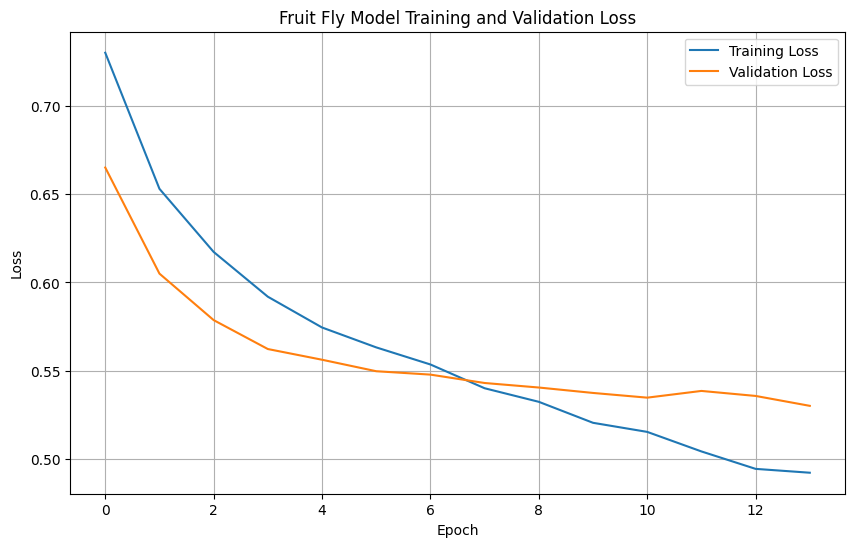

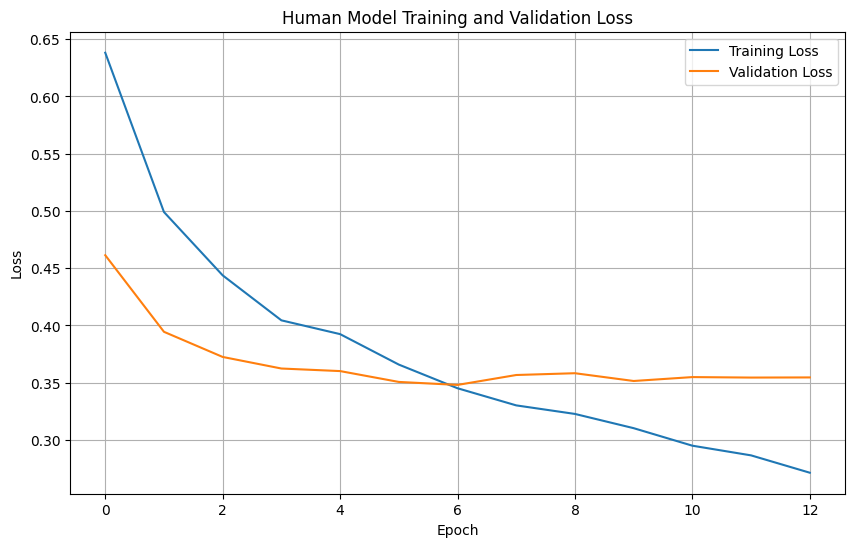

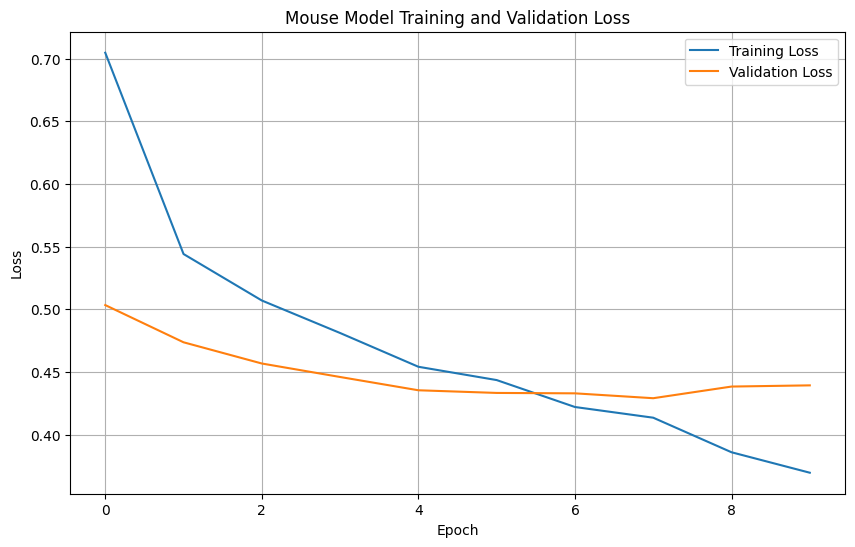

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# for Fruit Fly
X_train_ff, X_test_ff, y_train_ff, y_test_ff = train_test_split(
    X_fruit_fly, y_fruit_fly,
    test_size=0.15,
    random_state=42,
    stratify=y_fruit_fly
)

# for Human
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_human, y_human,
    test_size=0.15,
    random_state=42,
    stratify=y_human
)

# for Mouse
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_mouse, y_mouse,
    test_size=0.15,
    random_state=42,
    stratify=y_mouse
)

print(f"Fruit Fly: {len(X_train_ff)} training, {len(X_test_ff)} testing samples")
print(f"Human:     {len(X_train_h)} training, {len(X_test_h)} testing samples")
print(f"Mouse:     {len(X_train_m)} training, {len(X_test_m)} testing samples")


print("Fruit Fly:")
results_ff = train_and_evaluate_species_model(
    X_train_ff, y_train_ff, X_test_ff, y_test_ff, "Fruit Fly"
)

print("Human:")
results_h = train_and_evaluate_species_model(
    X_train_h, y_train_h, X_test_h, y_test_h, "Human"
)

print("Mouse:")
results_m = train_and_evaluate_species_model(
    X_train_m, y_train_m, X_test_m, y_test_m, "Mouse"
)


print(f" FRUIT FLY:")
print(classification_report(y_test_ff, results_ff['predictions'], labels=[1, 0], target_names=['Positive (oriC)', 'Negative (Non-oriC)']))

print(f"\n HUMAN:")
print(classification_report(y_test_h, results_h['predictions'], labels=[1, 0], target_names=['Positive (oriC)', 'Negative (Non-oriC)']))

print(f"\n MOUSE:")
print(classification_report(y_test_m, results_m['predictions'], labels=[1, 0], target_names=['Positive (oriC)', 'Negative (Non-oriC)']))

def plot_loss(history, species_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{species_name} Model Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(results_ff['history'], "Fruit Fly")
plot_loss(results_h['history'], "Human")
plot_loss(results_m['history'], "Mouse")

In [ ]:

data_dir_independent = "/kaggle/input/tri-ori/Tri-Ori/independent"
files_independent_ff = ["Ind-Bg3_F_F.txt", "Ind-KC_F_F.txt", "Ind-S2_F_F.txt"]
files_independent_h = ["Ind-K562_Human.txt", "Ind-MCF7_Human.txt"]
files_independent_m = ["Ind-ES_Mouse.txt", "Ind-P19_Mouse.txt", "Ind-MEF_Mouse.txt"]

df_independent_ff = load_fasta_data(data_dir_independent, files_independent_ff)
df_independent_h = load_fasta_data(data_dir_independent, files_independent_h)
df_independent_m = load_fasta_data(data_dir_independent, files_independent_m)

#calculating everything for independent sets
df_independent_ff_kmer = pd.DataFrame({
    'label': df_independent_ff['label'],
    'kmer_counts': df_independent_ff['seq'].apply(lambda seq: count_kmers(seq, k_size))
})
df_independent_ff_kmerVec = pd.DataFrame({
    'label': df_independent_ff_kmer['label'],
    'kmer_frequency_vector': df_independent_ff_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})

df_independent_h_kmer = pd.DataFrame({
    'label': df_independent_h['label'],
    'kmer_counts': df_independent_h['seq'].apply(lambda seq: count_kmers(seq, k_size))
})
df_independent_h_kmerVec = pd.DataFrame({
    'label': df_independent_h_kmer['label'],
    'kmer_frequency_vector': df_independent_h_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})

df_independent_m_kmer = pd.DataFrame({
    'label': df_independent_m['label'],
    'kmer_counts': df_independent_m['seq'].apply(lambda seq: count_kmers(seq, k_size))
})
df_independent_m_kmerVec = pd.DataFrame({
    'label': df_independent_m_kmer['label'],
    'kmer_frequency_vector': df_independent_m_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})

# feature matrices
X_independent_ff, _ = prepare_feature_matrix(df_independent_ff_kmerVec)
y_independent_ff = df_independent_ff_kmerVec['label'].values

X_independent_h, _ = prepare_feature_matrix(df_independent_h_kmerVec)
y_independent_h = df_independent_h_kmerVec['label'].values

X_independent_m, _ = prepare_feature_matrix(df_independent_m_kmerVec)
y_independent_m = df_independent_m_kmerVec['label'].values


def evaluate_model_on_independent_data(model_results, X_independent, y_independent, trained_species, independent_species):

    print(f"EVALUATING {trained_species.upper()} MODEL {independent_species.upper()}")


    scaler = model_results['scaler']
    model = model_results['model']

    X_independent_scaled = scaler.transform(X_independent)

    y_pred_proba = model.predict(X_independent_scaled)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print(classification_report(y_independent, y_pred, labels=[1, 0], target_names=['Positive (oriC)', 'Negative (Non-oriC)']))



evaluate_model_on_independent_data(results_ff, X_independent_ff, y_independent_ff, "Fruit Fly", "Fruit Fly")
evaluate_model_on_independent_data(results_ff, X_independent_h, y_independent_h, "Fruit Fly", "Human")
evaluate_model_on_independent_data(results_ff, X_independent_m, y_independent_m, "Fruit Fly", "Mouse")


evaluate_model_on_independent_data(results_h, X_independent_h, y_independent_h, "Human", "Human")
evaluate_model_on_independent_data(results_h, X_independent_ff, y_independent_ff, "Human", "Fruit Fly")
evaluate_model_on_independent_data(results_h, X_independent_m, y_independent_m, "Human", "Mouse")


evaluate_model_on_independent_data(results_m, X_independent_m, y_independent_m, "Mouse", "Mouse")
evaluate_model_on_independent_data(results_m, X_independent_ff, y_independent_ff, "Mouse", "Fruit Fly")
evaluate_model_on_independent_data(results_m, X_independent_h, y_independent_h, "Mouse", "Human")

Shortest sequence  300
Longest  sequence  300

Total sequences : 16,000
Class balance   : Counter({1: 8000, 0: 8000})

Break-down per file:
  Ind-Bg3_F_F.txt  Pos=2000  Neg=2000
  Ind-KC_F_F.txt  Pos=3000  Neg=3000
  Ind-S2_F_F.txt  Pos=3000  Neg=3000


,seq,label
9927,ACACCGGTCTTTAACGAAGACGATATCCGATGGACGAACATTAACG...,0
10294,TGTTCGGAAGGAGAAGTGATAAACAAGGATCACTGCCACAACCTGG...,1
6579,ATTCTATATTTACCTAAAATGTTAAAACATAATTACTATATTACTA...,1
13430,ACGCGGTGCCGCAGTGAAGCTGAAGGGTAAAGACATGGGCTTCTAT...,0
9000,TTCTTTTGGGCGTCCATCCAGCAAATTTATAACTGTTGCGGCCAAT...,0





Shortest sequence  300
Longest  sequence  300

Total sequences : 4,000
Class balance   : Counter({1: 2000, 0: 2000})

Break-down per file:
  Ind-K562_Human.txt  Pos=1000  Neg=1000
  Ind-MCF7_Human.txt  Pos=1000  Neg=1000


,seq,label
81,AGGAACAGGTCCTTCGGGGAGGGAAAGGTTCTCGACGAGGACCGGG...,1
3174,AAGCAGCCAGGAGAGTCACCTAGGGTGACTCCTGGGTGACTCCTTG...,0
264,CTGGGCAGCAAACAAGACAAAACAAAAAGATAAACACATAAAAGAT...,1
86,CTTCGATGTTAATGTCTGACAGTCGACCCAGAAAAGTACCGACCCC...,1
2812,ATGGGACACAGGGACGACACGATCCGGGTCCAGGGAAAGGGACCGG...,1





Shortest sequence  300
Longest  sequence  300

Total sequences : 6,000
Class balance   : Counter({1: 3000, 0: 3000})

Break-down per file:
  Ind-ES_Mouse.txt  Pos=1000  Neg=1000
  Ind-P19_Mouse.txt  Pos=1000  Neg=1000
  Ind-MEF_Mouse.txt  Pos=1000  Neg=1000


,seq,label
355,ACAGGCGCCGCCCCTCCGCCCCAGTCACTGAGCCGCCGCCGAGGAC...,1
2445,GGCGAACCTTCATCATGTCCTGTACTCACCTGGAGGACCAGTCCAG...,1
1716,TTTCCAGATTGGTTTGGAACTCACTATGTAGTCTAGCCTTGAATTC...,0
4477,CCCGGCGGCGGGCGGGCCGGGAGCGAGCGAGCGAGCGGAGGCGCGC...,1
2428,GGGACGTGAGCTGCTTACCTGGGGCTGTGCTCTTGAGTGGCAACAG...,1





EVALUATING FRUIT FLY MODEL FRUIT FLY
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                     precision    recall  f1-score   support

    Positive (oriC)       0.79      0.66      0.72      8000
Negative (Non-oriC)       0.71      0.82      0.76      8000

           accuracy                           0.74     16000
          macro avg       0.75      0.74      0.74     16000
       weighted avg       0.75      0.74      0.74     16000

EVALUATING FRUIT FLY MODEL HUMAN
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                     precision    recall  f1-score   support

    Positive (oriC)       0.42      0.45      0.43      2000
Negative (Non-oriC)       0.41      0.38      0.40      2000

           accuracy                           0.41      4000
          macro avg       0.41      0.42      0.41      4000
       weighted avg       0.41      0.41      0.41      4000

EVALUATING FRUIT FLY MODEL MOUSE
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                     precision   

# Training Combining all Data

In [ ]:
import pandas as pd
from collections import Counter

# Combined species
df_combined = pd.concat([df_fruit_fly, df_human, df_mouse], ignore_index=True)

display(df_combined.sample(5))
print(f"\nTotal sequences in combined dataset: {len(df_combined):,}")
print(f"Class balance in combined dataset: {Counter(df_combined.label)}")


df_combined_kmer = pd.DataFrame({
    'label': df_combined['label'],
    'kmer_counts': df_combined['seq'].apply(lambda seq: count_kmers(seq, k_size))
})

combined_species_vec = pd.DataFrame({
    'label': df_combined_kmer['label'],
    'kmer_frequency_vector': df_combined_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})


df_combined_aug = augment_dataframe(combined_species_vec, n_augments=1)

display(df_combined_aug.sample(5))
print(f"\nTotal sequences in augmented combined dataset: {len(df_combined_aug):,}")
print(f"Class balance in augmented combined dataset: {Counter(df_combined_aug.label)}")

,seq,label
1158,TTACCCGGGTTGCGAAGGCACAAATTAATCTCTGCCTTTTCCGAAC...,1
21806,CTCTGCCCCTGTCTCCTGCTCCCTTTTTCCCTCTACCTGGCTGCCC...,1
29382,TGGATCCAGAAGCAGTAGTTTGCTGATTGCTGCCGAAGAATGCTGT...,0
27844,GGGGGCGGGGCATGTGTGCCATGGTGCACATGTGGAGGTCAGAGGA...,1
8620,AATTATGAACAACGTAAAAGTTTCTGTTGAAGAAAAGCATTTGTTA...,0



Total sequences in combined dataset: 33,053
Class balance in combined dataset: Counter({1: 16537, 0: 16516})


,label,kmer_frequency_vector
11723,1,"{'TCGAA': 0.0033783783783783786, 'CGAAG': 0.00..."
9561,0,"{'TCGGA': 0.0033783783783783786, 'CGGAA': 0.00..."
33063,1,"{'GGCGG': 0.006187889502907866, 'GCGGT': 0.0, ..."
45517,1,"{'ATTGT': 0.0031487459015802585, 'TTGTT': 0.01..."
39689,1,"{'TTTGG': 0.0, 'TTGGT': 0.01685622850236954, '..."



Total sequences in augmented combined dataset: 66,106
Class balance in augmented combined dataset: Counter({1: 33074, 0: 33032})


# Train and Test on Combined dataset

Combined Augmented: 66106 samples, 1024 k-mer features

 CLASS DISTRIBUTION:
Combined Augmented - Positive: 33074, Negative: 33032

Combined Augmented: 56190 training, 9916 testing
COMBINED:
Training: 56190 samples, 1024 features
Test: 9916 samples


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5506 - loss: 0.7249 - val_accuracy: 0.6454 - val_loss: 0.6133 - learning_rate: 0.0010
Epoch 2/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6506 - loss: 0.6277 - val_accuracy: 0.7014 - val_loss: 0.5729 - learning_rate: 0.0010
Epoch 3/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6937 - loss: 0.5968 - val_accuracy: 0.7116 - val_loss: 0.5635 - learning_rate: 0.0010
Epoch 4/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7087 - loss: 0.5805 - val_accuracy: 0.7124 - val_loss: 0.5596 - learning_rate: 0.0010
Epoch 5/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7156 - loss: 0.5723 - val_accuracy: 0.7134 - val_loss: 0.5536 - learning_rate: 0.0010
Epoch 6/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7205 - loss: 0.5662 - val_accuracy: 0.7157 - val_loss: 0.5519 - learning_rate: 0.0010
Epoch 7/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.

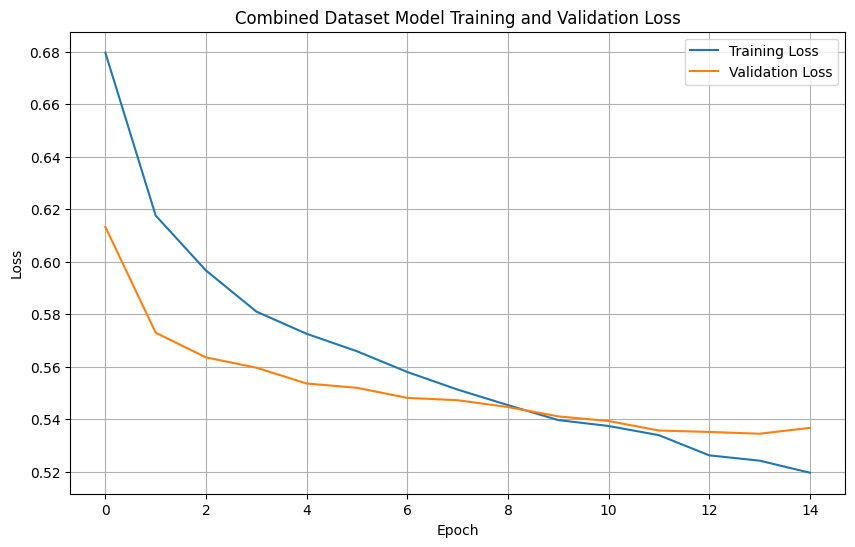

In [ ]:
#feature matrix
X_combined, kmers_combined = prepare_feature_matrix(df_combined_aug)
y_combined = df_combined_aug['label'].values

print(f"Combined Augmented: {X_combined.shape[0]} samples, {X_combined.shape[1]} k-mer features")
print(f"\n CLASS DISTRIBUTION:")
print(f"Combined Augmented - Positive: {sum(y_combined)}, Negative: {len(y_combined)-sum(y_combined)}")


X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined, y_combined,
    test_size=0.15,
    random_state=42,
    stratify=y_combined
)

print(f"\nCombined Augmented: {len(X_train_combined)} training, {len(X_test_combined)} testing")

#passing for training
results_combined = train_and_evaluate_species_model(
    X_train_combined, y_train_combined, X_test_combined, y_test_combined, "Combined"
)

print(f"\n COMBINED DATASET:")
print(classification_report(y_test_combined, results_combined['predictions'], labels=[1, 0], target_names=['Positive (oriC)', 'Negative (Non-oriC)']))

plot_loss(results_combined['history'], "Combined Dataset")

# Testing Independent Data on this Combined Model

In [ ]:
evaluate_model_on_independent_data(results_combined, X_independent_ff, y_independent_ff, "Combined", "Fruit Fly (Independent)")
evaluate_model_on_independent_data(results_combined, X_independent_h, y_independent_h, "Combined", "Human (Independent)")
evaluate_model_on_independent_data(results_combined, X_independent_m, y_independent_m, "Combined", "Mouse (Independent)")

EVALUATING COMBINED MODEL FRUIT FLY (INDEPENDENT)
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                     precision    recall  f1-score   support

    Positive (oriC)       0.74      0.67      0.70      8000
Negative (Non-oriC)       0.70      0.77      0.73      8000

           accuracy                           0.72     16000
          macro avg       0.72      0.72      0.72     16000
       weighted avg       0.72      0.72      0.72     16000

EVALUATING COMBINED MODEL HUMAN (INDEPENDENT)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                     precision    recall  f1-score   support

    Positive (oriC)       0.71      0.89      0.79      2000
Negative (Non-oriC)       0.85      0.63      0.72      2000

           accuracy                           0.76      4000
          macro avg       0.78      0.76      0.75      4000
       weighted avg       0.78      0.76      0.75      4000

EVALUATING COMBINED MODEL MOUSE (INDEPENDENT)
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st